In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import cv2

CLASSES = 2
BATCH_SIZE = 16
input_size = 244
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
import pandas as pd

def read_label_file(label_file):
    data = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            # Split each line by space (assuming space-separated values)
            parts = line.strip().split()
            # Extract relevant information from the line
            image_path = parts[0]  # Assuming the image path is the first item
            # Assuming the rest of the items in the line are label values
            labels = parts[1:]
            # Append the extracted information as a tuple to the data list
            data.append((image_path, *labels))
    # Convert the data list to a pandas DataFrame
    df = pd.DataFrame(data)  
    return df

# Read Train Labels
label_file = 'combined_classification_dataset/combined_train_labels.txt'
train_df = read_label_file(label_file)
train_df.drop(train_df.columns[1], axis=1, inplace=True)
train_df.columns = ["Image_path", 'label_x', 'label_y', 'label_w', 'label_h', 'class']
print(train_df.head())  # Display the first few rows of the DataFrame


# Read Test Labels
label_file = 'combined_classification_dataset/combined_test_labels.txt'
test_df = read_label_file(label_file)
test_df.drop(test_df.columns[1], axis=1, inplace=True)
test_df.columns = ["Image_path", 'label_x', 'label_y', 'label_w', 'label_h', 'class']
print(test_df.head())  # Display the first few rows of the DataFrame

                                          Image_path     label_x     label_y  \
0  frame_0149_jpg.rf.ad848af69b7adc7a4d67f8d82b92...      0.6625  0.15390625   
1  frame_0161_jpg.rf.a7d9f87c6556f2d980a350eb857d...  0.72265625    0.190625   
2  frame_0077_jpg.rf.33fd47b720cd708a804198f25d15...  0.40078125  0.34765625   
3  frame_0063_jpg.rf.4624fa9ce940d4a3064911fcb3ce...  0.42578125      0.3375   
4  frame_0175_jpg.rf.c07c9544bfd1df4e226182f80058...  0.77109375  0.24296875   

      label_w     label_h class  
0    0.246875   0.2265625     1  
1       0.225  0.24609375     1  
2  0.47578125   0.0984375     0  
3   0.4109375   0.1609375     0  
4     0.29375   0.3109375     1  
                                          Image_path     label_x     label_y  \
0  frame_0001_jpg.rf.8b7a3fd43952e6fb49d005af8ab5...     0.61875  0.25546875   
1  frame_0101_jpg.rf.e9950d83f267efea842042bb5d08...  0.40703125   0.3328125   
2  frame_0110_jpg.rf.19798f26be9e970155fcfd9e0056...      0.3875  0.3210937

In [3]:
train_df.dtypes

Image_path    object
label_x       object
label_y       object
label_w       object
label_h       object
class         object
dtype: object

# USE THIS

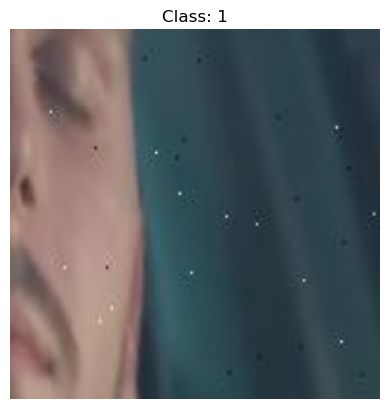

In [4]:
import os

def preprocess_image_and_label(image_name, label_x, label_y, label_w, label_h, class_label, target_size=(244, 244)):
    # Construct the full image path
    image_path = os.path.join('combined_classification_dataset', 'train', 'images', image_name)
    
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")t
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    x, y, w, h = int(float(label_x) * width), int(float(label_y) * height), int(float(label_w) * width), int(float(label_h) * height)
    cropped_image = image[y:y+h, x:x+w]
    cropped_image = cv2.resize(cropped_image, target_size)
    
    # Preprocess the class label
    class_label = int(class_label)  # Convert to integer
    
    return cropped_image, class_label

# Example usage:
image_name = train_df['Image_path'][0]  # Assuming this contains just the image filename
label_x = train_df['label_x'][0]
label_y = train_df['label_y'][0]
label_w = train_df['label_w'][0]
label_h = train_df['label_h'][0]
class_label = train_df['class'][0]

image, class_label = preprocess_image_and_label(image_name, label_x, label_y, label_w, label_h, class_label)

# Now you can use image and class_label for further processing or display
plt.imshow(image)
plt.title(f"Class: {class_label}")
plt.axis('off')
plt.show()


In [5]:
def preprocess_image_and_label_train(image_name, label_x, label_y, label_w, label_h, class_label, target_size=(244, 244)):
    # Construct the full image path
    image_path = os.path.join('combined_classification_dataset', 'train', 'images', image_name)
    
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    x, y, w, h = int(float(label_x) * width), int(float(label_y) * height), int(float(label_w) * width), int(float(label_h) * height)
    cropped_image = image[y:y+h, x:x+w]
    cropped_image = cv2.resize(cropped_image, target_size)
    
    # Preprocess the class label
    class_label = int(class_label)  # Convert to integer
    
    return cropped_image, class_label

# Lists to store preprocessed images and their corresponding class labels
train_preprocessed_images = []
train_class_labels = []

# Iterate through each row in train_df and preprocess the images and labels
for index, row in train_df.iterrows():
    image_name = row['Image_path']  # Assuming this contains just the image filename
    label_x = row['label_x']
    label_y = row['label_y']
    label_w = row['label_w']
    label_h = row['label_h']
    class_label = row['class']

    # Preprocess the image and label
    image, class_label = preprocess_image_and_label_train(image_name, label_x, label_y, label_w, label_h, class_label)
    
    # Append preprocessed image and class label to lists
    train_preprocessed_images.append(image)
    train_class_labels.append(class_label)

In [6]:
test_preprocessed_images = []
test_class_labels = []

def preprocess_image_and_label_test(image_name, label_x, label_y, label_w, label_h, class_label, target_size=(244, 244)):
    # Construct the full image path
    image_path = os.path.join('combined_classification_dataset', 'test', 'images', image_name)
    
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    x, y, w, h = int(float(label_x) * width), int(float(label_y) * height), int(float(label_w) * width), int(float(label_h) * height)
    cropped_image = image[y:y+h, x:x+w]
    cropped_image = cv2.resize(cropped_image, target_size)
    
    # Preprocess the class label
    class_label = int(class_label)  # Convert to integer
    
    return cropped_image, class_label


# Iterate through each row in test_df and preprocess the images and labels
for index, row in test_df.iterrows():
    image_name = row['Image_path']  # Assuming this contains just the image filename
    label_x = row['label_x']
    label_y = row['label_y']
    label_w = row['label_w']
    label_h = row['label_h']
    class_label = row['class']

    # Preprocess the image and label
    image, class_label = preprocess_image_and_label_test(image_name, label_x, label_y, label_w, label_h, class_label)
    
    # Append preprocessed image and class label to lists
    test_preprocessed_images.append(image)
    test_class_labels.append(class_label)


In [7]:
train_images = np.array(train_preprocessed_images)
train_labels = np.array(train_class_labels)

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create the base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(244, 244, 3))

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Adjust num_classes based on your dataset
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1/10
25/25 [==============================] - 63s 2s/step - loss: 0.2743 - accuracy: 0.8816
Epoch 2/10
25/25 [==============================] - 61s 2s/step - loss: 0.1093 - accuracy: 0.9640
Epoch 3/10
25/25 [==============================] - 56s 2s/step - loss: 0.1099 - accuracy: 0.9678
Epoch 4/10
25/25 [==============================] - 48s 2s/step - loss: 0.0235 - accuracy: 0.9936
Epoch 5/10
25/25 [==============================] - 56s 2s/step - loss: 0.0488 - accuracy: 0.9871
Epoch 6/10
25/25 [==============================] - 63s 2s/step - loss: 0.0183 - accuracy: 0.9949
Epoch 7/10
25/25 [==============================] - 56s 2s/step - loss: 0.0263 - accuracy: 0.9923
Epoch 8/10
25/25 [==============================] - 65s 3s/step - loss: 0.0152 - accuracy: 0.9949
Epoch 9/10
25/25 [==============================] - 60s 2s/step - loss: 0.0217 - accuracy: 0.9923
Epoch 10/10
25/25 [==============================] - 56s 2s/step - loss: 0.0116 - accuracy: 0.9974


In [14]:
test_images = np.array(test_preprocessed_images)
test_labels = np.array(test_class_labels)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 83ms/step - loss: 0.1517 - accuracy: 0.9487
Test accuracy: 0.9487179517745972


In [13]:
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display predicted labels
print("Predicted labels:", predicted_labels)

2/2 [==============================] - 1s 88ms/step
Predicted labels: [1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0
 0 0]


In [9]:
print(test_class_labels)

[0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]


In [10]:
new_image_path = os.path.join('combined_classification_dataset', 'new_image.jpeg')

# Read the new image
new_image = cv2.imread(new_image_path)
if new_image is None:
    print(f"Error: Unable to load image from {new_image_path}")
else:
    # Preprocess the new image (resize, normalize, etc.)
    preprocessed_new_image = cv2.resize(new_image, (244, 244))  # Resize to match the input size of your model
    
    # Make prediction on the preprocessed new image
    prediction = model.predict(np.expand_dims(preprocessed_new_image, axis=0))
    
    # Convert prediction to class label
    predicted_label = np.argmax(prediction)
    
    print("Predicted label for the new image:", predicted_label)

1/1 [==============================] - 1s 728ms/step
Predicted label for the new image: 0


In [11]:
model.save('efficientnet_model.h5')

/Users/vedantpaithane/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [105]:
summary_str = []
model.summary(print_fn=lambda x: summary_str.append(x))
summary = "\n".join(summary_str)
print(summary)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 128)               163968    
                                                                 
 dense_6 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4213797 (16.07 MB)
Trainable params: 4171774 (15.91 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.89      1.00      0.94        16

    accuracy                           0.95        39
   macro avg       0.94      0.96      0.95        39
weighted avg       0.95      0.95      0.95        39

Confusion Matrix:
[[21  2]
 [ 0 16]]


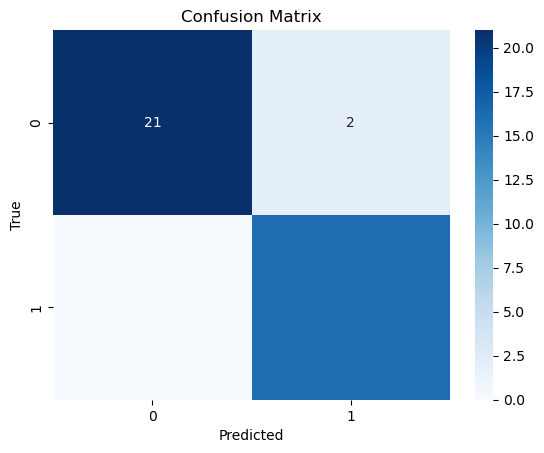

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

# Step 3: Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()